# Analyses: a look into the data

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.3g}'.format
import numpy as np
import pickle
from itertools import islice, cycle
import random

import helper_functions as hf

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc, rcParams
#rc('font', weight='normal')
%matplotlib inline  


import seaborn as sns
#sns.set(font_scale=1.0)

from scipy import stats as st
import math
from adjustText import adjust_text


# plt.rcParams["font.weight"] = "normal"
plt.style.use(['ggplot'])  # seaborn-whitegrid
#plt.rcParams["font.scale"] = 1.0

# Load data

In [2]:
# must be the same as the HIOT Excel sheetname
scenario = '2019-12-02_WW'

In [3]:
DATA_PATH = "../data/"
SCENARIO_PATH = "../results/" + scenario + "/"
print(SCENARIO_PATH)

../results/2019-12-02_WW/


#### Matching results

In [4]:
# Matching results
M = pd.read_excel(f'{SCENARIO_PATH}matching_results/EItoEX_matching_results_HIOT_manual.xlsx', 
                  sheet_name='data', skiprows=[0])
M.drop(labels=["Unnamed: 0"], axis=1, inplace=True)
print(M.shape)
M.head(2)

(4567, 22)


,key,functional unit,unitName,PhysicalUnit,ProductTypeName_of_hiot,unit,ISIC 1,ISIC 2,ISIC 3,ISIC 4,ISIC v4,CPC,activityName,name,ProductTypeName,geography,CountryCode,Continent,"('IPCC 2013', 'climate change', 'GWP 100a')",CarbonFootprint,diff,dev
0,"('ecoinvent 3.4 cutoff', 'd0bd9c43e8becfcc1a3d...",1,kg,kg,Cultivation of wheat,kg CO2-eq/kg,"A:Agriculture, forestry and fishing","01:Crop and animal production, hunting and rel...",011:Growing of non-perennial crops,"0111:Growing of cereals (except rice), legumin...","0111:Growing of cereals (except rice), legumin...","01112: Wheat, other",wheat production,wheat grain,Wheat,AU,AU,Australia,0.656,0.307,-0.349,1.14
1,"('ecoinvent 3.4 cutoff', 'f053a42fddfcd4278d97...",1,kg,kg,Cultivation of wheat,kg CO2-eq/kg,"A:Agriculture, forestry and fishing","01:Crop and animal production, hunting and rel...",011:Growing of non-perennial crops,"0111:Growing of cereals (except rice), legumin...","0111:Growing of cereals (except rice), legumin...","01112: Wheat, other",wheat production,wheat grain,Wheat,Canada without Quebec,CA,North America,0.501,0.327,-0.173,0.53


#### ecoinvent

In [5]:
# ecoinvent
AO = pd.read_excel(f"{DATA_PATH}ecoinvent/activity_overview_3.4_cut-off_LCIA_results.xlsx")
AO['ISIC code'] = AO['ISIC code'].astype(str)
AO = AO[AO['specialActivityType'] == 'ordinary transforming activity']  # remove markets
AO = AO[AO['geography'] != 'RoW']  # remove RoW
print(AO.shape)
AO.head(2)

(7986, 37)


,key,#,id,filename,activityName,geography,startDate,endDate,specialActivityType,technologyLevel,inheritance status,parentActivityId,tags,synonyms,ISIC v4,ISIC code,ISIC name,specialty production,constrained market,accessRestrictedTo,dataEntryBy,dataGenerator,isActiveAuthor,group,name,CPC,amount,unitName,productionVolumeAmount,absolute PV,productionVolumeComment,price,By-product classification,mft,functional unit,"('IPCC 2013', 'climate change', 'GWP 100a')_all_CFs","('IPCC 2013', 'climate change', 'GWP 100a')"
1,"('ecoinvent 3.4 cutoff', '001145735c7cee63ae10...",402,0766970d-6c54-497e-b458-2626f56d9e0c,0766970d-6c54-497e-b458-2626f56d9e0c_45fbbc41-...,"treatment of municipal solid waste, incineration",AT,2006-01-01,2017-12-31,ordinary transforming activity,Current,allocated dataset,df38bb66-a99b-446f-9160-a98c6c640cd9,NaN,municipal waste incineration\n Siedlungsabfall...,3821:Treatment and disposal of non-hazardous w...,3821,Treatment and disposal of non-hazardous waste,True,NaN,1,Karin Treyer,Karin Treyer,True,ReferenceProduct,"heat, for reuse in municipal waste incineratio...",17300: Steam and hot water,1,MJ,4.82e+09,True,NaN,0.0106,allocatable product,non-mft,1,0,0
2,"('ecoinvent 3.4 cutoff', '00127979f70f2a8748ac...",14707,fcbe495e-7474-40c0-a735-f4a55937edac,fcbe495e-7474-40c0-a735-f4a55937edac_71e2f1db-...,"treatment of blast furnace gas, in power plant",NO,1980-01-01,2017-12-31,ordinary transforming activity,Current,allocated dataset,0cc3dfbc-2c38-4c31-9300-3708dfd6dcdc,fossil fuels\n industrial gas power,BFG\n top gas,"3510:Electric power generation, transmission a...",3510,"Electric power generation, transmission and di...",False,NaN,1,Karin Treyer,Karin Treyer,True,ReferenceProduct,"heat, district or industrial, other than natur...",17300: Steam and hot water,1,MJ,2.07e+08,True,Calculated from production volume of reference...,0.0106,allocatable product,non-mft,1,0.113,0.113


#### EXIOBASE

In [6]:
EX = pd.read_excel(f"{SCENARIO_PATH}exiobase/hiot_results.xlsx")
#EX.drop([0], axis=0, inplace=True)
print(EX.shape)
EX.head(2)

(7012, 12)


,Unnamed: 0,#,CountryCode,ProductTypeName_of_hiot,product code 1,product code 2,OriginalPhysicalUnit,GHGs-eq - tonnes,PhysicalUnit,CarbonFootprint,unit,ProductTypeName
0,1,2,AU,Cultivation of wheat,c01.b,P_WHEA,tonnes,0.307,kg,0.307,kg CO2-eq/kg,Wheat
1,2,3,AU,Cultivation of cereal grains nec,c01.c,P_OCER,tonnes,0.266,kg,0.266,kg CO2-eq/kg,Cereal grains nec


# Helper functions

In [7]:
def add_sample_size(yticks, grouped_on, get_ISIC1=False, max_length=200):
    nb_dict = M[grouped_on].value_counts(ascending=False).to_dict()
    new_yticks = list()
    total_number = 0
    ISIC1_text = ""
    for t in yticks:
        if get_ISIC1:
            ISIC1_text = " (" + str(best_matching_PTN_ISIC1.loc[t.get_text()].values[0][:1]) + ")"
            
        new_yticks.append(t.get_text()[:max_length] + ISIC1_text + ": " + str(nb_dict.get(t.get_text(), "-1")))
    return new_yticks

# A) A look into the data

In [8]:
print("Matching success:")
print("Total matches:", len(M))
print("EX sectors:", len(M["ProductTypeName"].unique()), "of", len(EX["ProductTypeName"].unique()))
print("EI sectors (ISIC):", len(M["ISIC v4"].unique()), "of", len(AO["ISIC code"].unique()))
print("EI sectors (CPC):", len(M["CPC"].unique()), "of", len(AO["CPC"].unique()))
print("EI activities:", len(M["key"].unique()), "of", len(AO["key"].unique()))
print("EI products:", len(M["name"].unique()), "of", len(AO["name"].unique()))
print("EI product-activity combinations:", len((M["name"]+M["activityName"]).unique()), "of", len((AO["name"]+AO["activityName"]).unique()))

print("EX geographies:", len(M["CountryCode"].unique()), "of", len(EX["CountryCode"].unique()))
print("EI geographies:", len(M["geography"].unique()), "of", len(AO["geography"].unique()))

print("EX units:", len(M["PhysicalUnit"].unique()), "of", len(EX["PhysicalUnit"].unique()))
print("EI units:", len(M["unitName"].unique()), "of", len(AO["unitName"].unique()))

print("\nAdditional stats:")
print("Check: How often is the same activity matched to different EX sectors? {:.2f}".format(len(M) / len(M["key"].unique())))
print("ISIC sections remaining after matching: ", M["ISIC 1"].unique())

Matching success:
Total matches: 4567
EX sectors: 84 of 162
EI sectors (ISIC): 114 of 185
EI sectors (CPC): 360 of 540
EI activities: 4567 of 7986
EI products: 1405 of 2851
EI product-activity combinations: 2084 of 4150
EX geographies: 50 of 50
EI geographies: 177 of 258
EX units: 2 of 3
EI units: 3 of 17

Additional stats:
Check: How often is the same activity matched to different EX sectors? 1.00
ISIC sections remaining after matching:  ['A:Agriculture, forestry and fishing' 'C:Manufacturing' nan
 'B:Mining and quarrying'
 'D:Electricity, gas, steam and air conditioning supply'
 'E:Water supply; sewerage, waste management and remediation activities'
 'N:Administrative and support service activities' 'F:Construction']


## Relative deviation

   0 = perfect match.
   1 = EI twice as high. 
-0.5 = EI has half the impacts.       
  -1 = EI has zero impacts. 
 <-1 = opposite sign


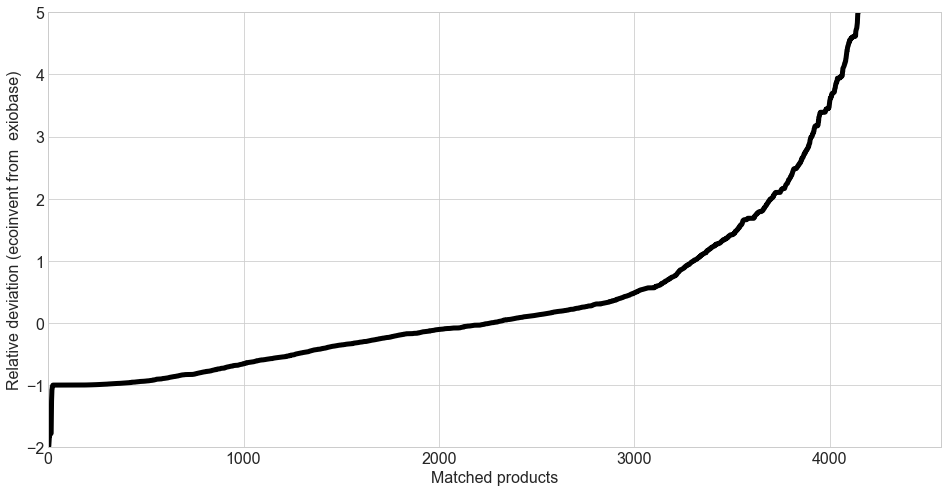

In [9]:
plt.style.use(['seaborn-whitegrid'])  # seaborn-whitegrid

fig, ax = plt.subplots()
ax = M["dev"].sort_values(ascending=True).plot(use_index=False, ylim=[-2,5], grid=True, ax=ax,
                                         figsize=(16,8), linewidth=5,  fontsize=16, color='black')  # 
ax.set_xlabel('Matched products', weight='normal', size='16')
ax.set_ylabel('Relative deviation (ecoinvent from  exiobase)', weight='normal', size='16')

# set limits to number of matched products
ax.set_xlim(0,len(M))

fig.savefig(f"{SCENARIO_PATH}figures/relative_deviation.png", bbox_inches='tight')
fig.savefig(f"{SCENARIO_PATH}figures/Figure4.svg", bbox_inches='tight')

print("   0 = perfect match.\n   1 = EI twice as high. \n-0.5 = EI has half the impacts. \
      \n  -1 = EI has zero impacts. \n <-1 = opposite sign")

In [10]:
l = [(M[M["dev"] > 0]['dev'].count(), "EI higher."),
    (M[(M["dev"] > -0.2) & (M["dev"] < 0.2)]['dev'].count(), "less than 20% difference."),
     (M[(M["dev"] > -1) & (M["dev"] < 1)]['dev'].count(), "less than 100% difference."),
     (M[M["dev"] > 1]['dev'].count(), "EI has more than 2x the impact."),
     (M[M["dev"] == -1]['dev'].count(), "EI has zero impacts."),
     (M[M["dev"] < -1]['dev'].count(), "datasets with opposite sign."),
    ]

for t in l:
    print(round(t[0]*100/len(M), 1),"%", t)


50.4 % (2301, 'EI higher.')
18.7 % (852, 'less than 20% difference.')
68.6 % (3132, 'less than 100% difference.')
27.7 % (1265, 'EI has more than 2x the impact.')
3.2 % (144, 'EI has zero impacts.')
0.6 % (26, 'datasets with opposite sign.')


In [11]:
total = M.shape[0]/100 # to have the percentage of total
l = [
    ((M[M["dev"] <= 0]['dev'].count() - M[M["dev"] < -1]['dev'].count()), "EI lower."),
    (M[M["dev"] > 0]['dev'].count(), "EI higher."),
    
    (M[M["dev"] < -1]['dev'].count(), "Opposite sign."),
    (M[(M["dev"] > -1) & (M["dev"] < -0.5)]['dev'].count(), "EI > factor 2 lower."),
    (M[(M["dev"] == -1)]['dev'].count(), "EI = zero impact"),
    (M[(M["dev"] >= -0.5) & (M["dev"] < 1)]['dev'].count(), "less than factor 2 difference."),
    (M[M["dev"] >= 1]['dev'].count(), "EI > factor 2 higher."),
]

for t in l:
    print(t[1], round(t[0]/total, 1), "%")


EI lower. 49.0 %
EI higher. 50.4 %
Opposite sign. 0.6 %
EI > factor 2 lower. 24.0 %
EI = zero impact 3.2 %
less than factor 2 difference. 44.5 %
EI > factor 2 higher. 27.7 %


In [12]:
print('Deviation minimum:', min(M['dev']), 'Deviation maximum:', max(M['dev']))

Deviation minimum: -9.30310338402766 Deviation maximum: 83658811.53515759


# Scatter plots and correlations

(4532, 22)
A:Agriculture, forestry and fishing
B:Mining and quarrying
C:Manufacturing
D:Electricity, gas, steam and air conditioning supply
E:Water supply; sewerage, waste management and remediation activities
F:Construction
N:Administrative and support service activities


NameError: name 'e' is not defined

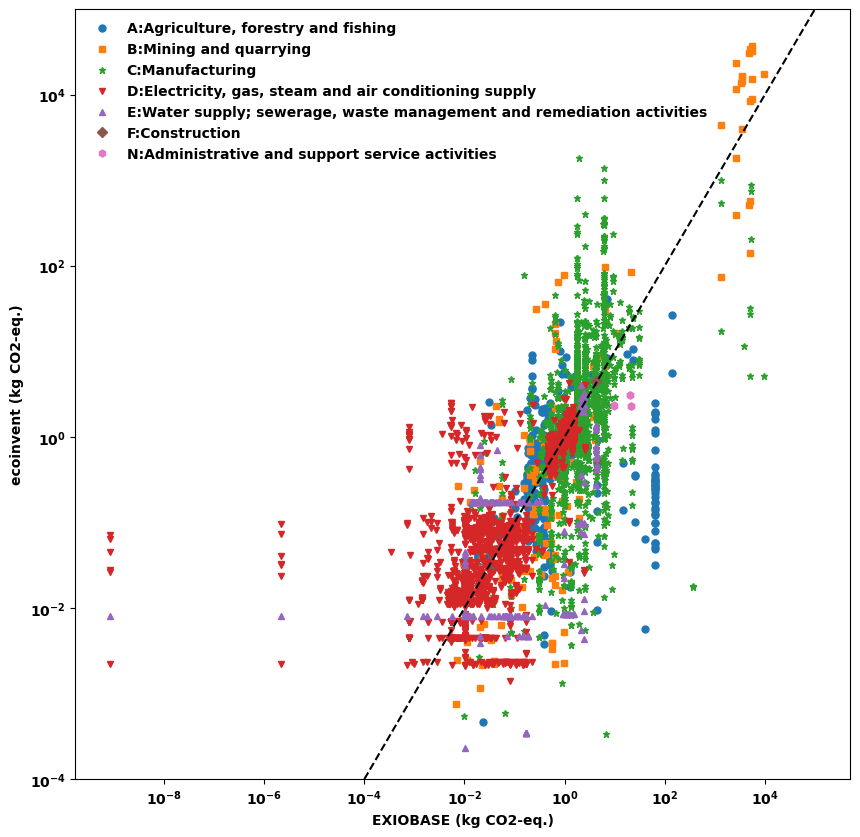

In [13]:
Mnz = M[M['CarbonFootprint'] > 0]
print(Mnz.shape)
grouped = Mnz.groupby("ISIC 1")


markers_list = ['o', 's', '*', 'v', '^', 'D', 'h', 'x', '+', '8', 'p', '<', '>', 'd', 'H']
marker_iter = cycle(markers_list)

mini = 1e-4
maxi = 1e5

# Plot
plt.style.use(['default'])

fig, ax = plt.subplots(figsize=(10,10))
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in grouped:
    print(name)
    ax.plot(group['CarbonFootprint'], group["('IPCC 2013', 'climate change', 'GWP 100a')"], 
            #loglog=True,
            marker=next(marker_iter), ms=5, linestyle='', label=name)
#ax.legend(loc='upper left', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
ax.legend(framealpha=0)
ax.set_xlabel('EXIOBASE (kg CO2-eq.)')
ax.set_ylabel('ecoinvent (kg CO2-eq.)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.plot([mini,maxi], [mini,maxi], color='black', linestyle='--')
ax.set_ylim(mini,maxi)
ax.set_xlim(e-9,maxi)
plt.show()
fig.savefig(f"{SCENARIO_PATH}figures/correlation_all_ISIC1_loglog.png", bbox_inches='tight')
fig.savefig(f"{SCENARIO_PATH}figures/Figure3.svg", bbox_inches='tight')

In [14]:
M["CarbonFootprint"].corr(M["('IPCC 2013', 'climate change', 'GWP 100a')"], method="spearman")

0.7059159969056591

### Electricity sector

In [15]:
product = "electricity, high voltage"
all_electricity = ['electricity, low voltage', 'electricity, medium voltage', 'electricity, high voltage']

In [16]:
M[M["name"].isin(all_electricity)][["CarbonFootprint", "('IPCC 2013', 'climate change', 'GWP 100a')"]].corr(method="spearman")

,CarbonFootprint,"('IPCC 2013', 'climate change', 'GWP 100a')"
CarbonFootprint,1,0.744
"('IPCC 2013', 'climate change', 'GWP 100a')",0.744,1


In [17]:
# spearman correlation for electricity sector
a = M[M["name"].isin(all_electricity)].groupby('ProductTypeName')[["CarbonFootprint", "('IPCC 2013', 'climate change', 'GWP 100a')"]].corr(method="spearman")
a.drop(columns="('IPCC 2013', 'climate change', 'GWP 100a')", inplace=True)
a.drop(index='CarbonFootprint', level=1, inplace=True)
a.rename(columns={'CarbonFootprint': 'correlation'}, inplace=True)
a.index = a.index.droplevel(level=1)
a.sort_values(by='correlation', ascending=False, inplace=True)
a.to_clipboard()
a

,correlation
ProductTypeName,
Electricity by coal,0.586
Electricity by wind,0.384
Electricity by gas,0.224
Electricity by petroleum and other oil derivatives,0.182
Electricity by hydro,-0.0347
Electricity nec,-0.0639
Electricity by nuclear,-0.0758
Electricity by biomass and waste,-0.165
Electricity by solar photovoltaic,-0.196


# B) Scatter plots

#### Filter data

In [18]:
filter_col = "name"
filter_by = "electricity, high voltage"
#filtered = M[M[filter_col] == filter_by]

all_electricity = ['electricity, low voltage', 'electricity, medium voltage', 'electricity, high voltage']

filtered = M[M[filter_col].isin(all_electricity)]
filtered.shape

(1717, 22)

#### Group data

In [19]:
groupby = "ProductTypeName"
grouped = filtered.groupby(groupby)

In [20]:
# abbreviations
GWP_ecoinvent = "('IPCC 2013', 'climate change', 'GWP 100a')"
GWP_EXIOBASE = "CarbonFootprint"

#### Plot

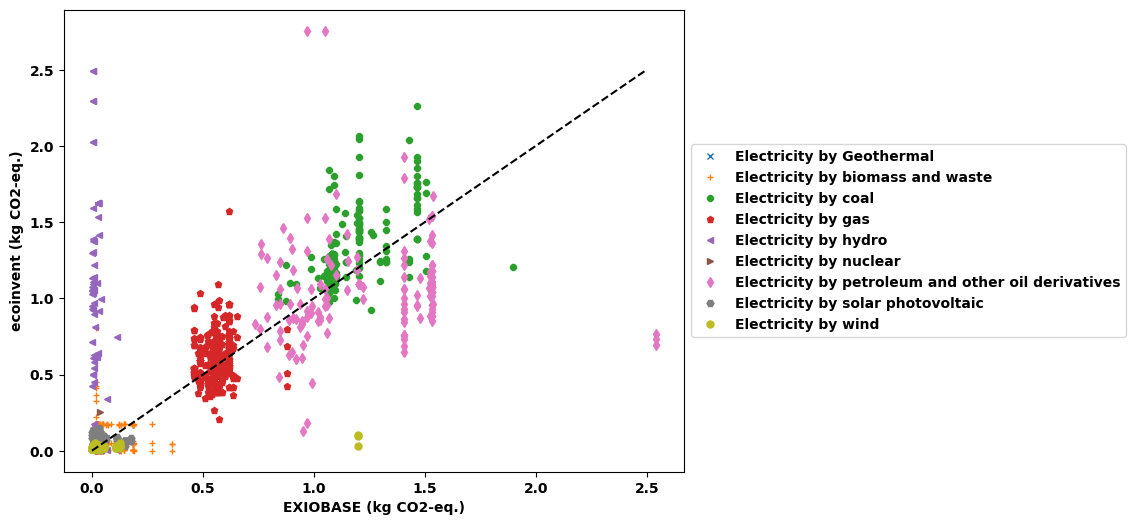

In [21]:
# Plot
fig, ax = plt.subplots(figsize=(8,6))
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

mini, maxi = 0, 2.5

for name, group in grouped:
    if name != 'Electricity nec':
        ax.plot(group[GWP_EXIOBASE], group[GWP_ecoinvent], marker=next(marker_iter), linestyle='', ms=5, label=name)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('EXIOBASE (kg CO2-eq.)')
ax.set_ylabel('ecoinvent (kg CO2-eq.)')
ax.plot([mini,maxi], [mini,maxi], color='black', linestyle='--')
plt.show()
fig.savefig(f"{SCENARIO_PATH}figures/correlation_electricity.png", bbox_inches='tight')
fig.savefig(f"{SCENARIO_PATH}figures/Figure7.svg", bbox_inches='tight')

(-1.5, 5.0)

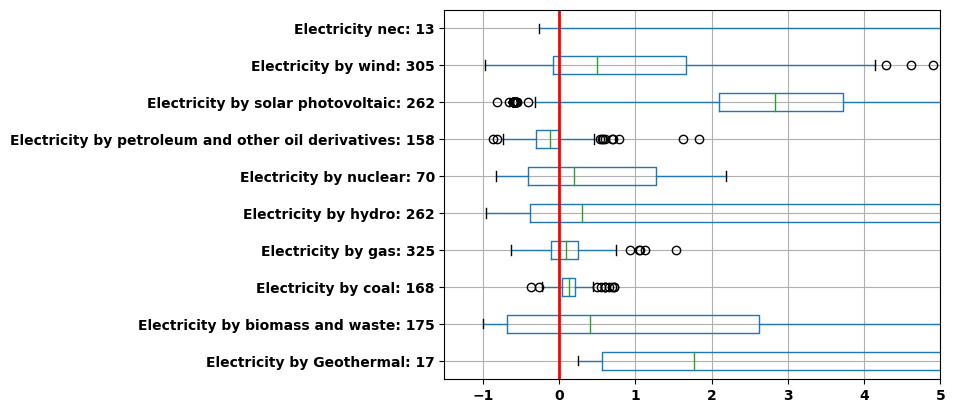

In [22]:
df_el = pd.DataFrame({col:vals['dev'] for col,vals in grouped})  # cols: PTN, vals: dev
ax = df_el.boxplot(vert=False,)
ytl = ax.set_yticklabels(add_sample_size(ax.get_yticklabels(), groupby))  # add sample sizes to yticklabels
ax.axvline(x=0, linewidth=2, color='r')
ax.set_xlim(-1.5, 5)

# C) Relative deviation

# Analyses

## Descriptive statistics by group
from: https://chrisalbon.com/python/data_wrangling/pandas_apply_operations_to_groups/

In [23]:
group_col = "ProductTypeName"
application_col = "CarbonFootprint"
M[application_col].groupby([M[group_col]]).describe().head(5)

,count,mean,std,min,25%,50%,75%,max
ProductTypeName,,,,,,,,
Aluminium and aluminium products,52,20.4,6.05,12,14.2,22.1,22.5,30
Aluminium ores and concentrates,2,0.0681,0.0221,0.0525,0.0603,0.0681,0.0759,0.0837
Animal products nec,2,7.18,0,7.18,7.18,7.18,7.18,7.18
Basic iron and steel and of ferro-alloys and first products thereof,21,4.52,0.829,2.57,4.37,4.37,5.26,5.55
Beverages,3,1.06,0.495,0.639,0.787,0.934,1.27,1.61


### Relative deviation (d_rel)

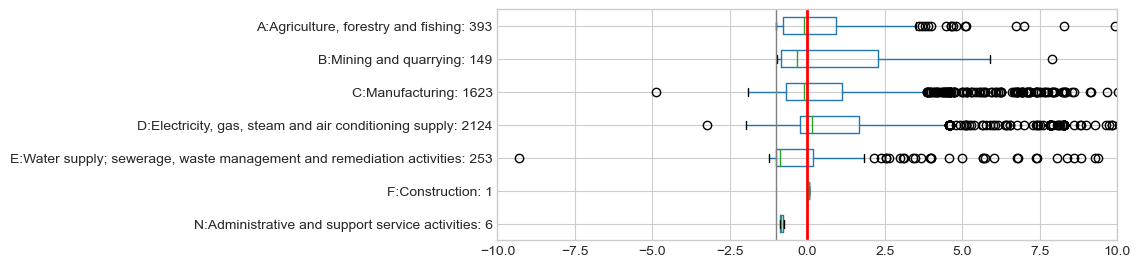

In [34]:
grouped_on = "ISIC 1"
grouped = M.groupby([M[grouped_on]])
df_dev = pd.DataFrame({col:vals['dev'] for col,vals in grouped})  # cols: PTN, vals: dev
# sort alphabetically
df_dev.sort_index(axis=1, inplace=True, ascending=False)
#print(df_dev.shape)
#print(df_dev.describe())

# figure
plt.style.use(['seaborn-whitegrid'])
figsize=(8,3)
fig, ax = plt.subplots(figsize=figsize)
ax = df_dev.boxplot(vert=False,)
ytl = ax.set_yticklabels(add_sample_size(ax.get_yticklabels(), grouped_on))  # add sample sizes to yticklabels
ax.axvline(x=0, linewidth=2, color='r')
ax.axvline(x=-1, linewidth=1, color='grey')
ax.set_xlim(-10, 10)
#print(df_dev.shape)
#fig.savefig(f"{SCENARIO_PATH}figures/Dev_by_ISIC1_manual.png", bbox_inches='tight')
#fig.savefig(f"{SCENARIO_PATH}figures/Figure5.svg", bbox_inches='tight')
#fig.savefig(f"{SCENARIO_PATH}figures/Figure5.pdf", bbox_inches='tight')
fig.savefig(f"{SCENARIO_PATH}figures/Figure 3.tif", bbox_inches='tight', dpi=300)

In [25]:
grouped['dev'].median()

ISIC 1
A:Agriculture, forestry and fishing                                     -0.107
B:Mining and quarrying                                                  -0.346
C:Manufacturing                                                         -0.125
D:Electricity, gas, steam and air conditioning supply                    0.144
E:Water supply; sewerage, waste management and remediation activities   -0.901
F:Construction                                                          0.0519
N:Administrative and support service activities                         -0.848
Name: dev, dtype: float64

In [26]:
df = df_dev.reindex(sorted(df_dev.columns), axis=1)
df.columns

Index(['A:Agriculture, forestry and fishing', 'B:Mining and quarrying',
       'C:Manufacturing',
       'D:Electricity, gas, steam and air conditioning supply',
       'E:Water supply; sewerage, waste management and remediation activities',
       'F:Construction', 'N:Administrative and support service activities'],
      dtype='object')

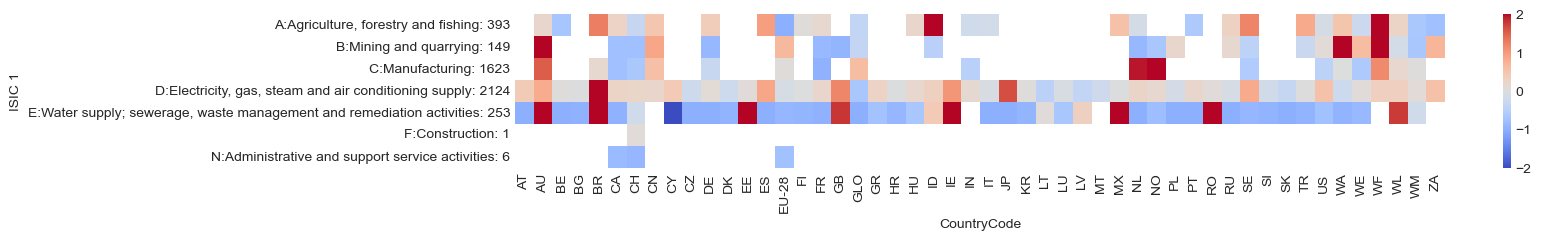

In [27]:
grouped = M['dev'].groupby([M['ISIC 1'], M["CountryCode"]]).median()  #.agg("mean")
figsize=(15,2)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.heatmap(grouped.unstack(), annot=False, ax=ax, cmap="coolwarm", center=0, vmin=-2, vmax=2)
ytl = ax.set_yticklabels(add_sample_size(ax.get_yticklabels(), 'ISIC 1'))  # add sample sizes to yticklabels
fig.savefig(f"{SCENARIO_PATH}figures/Dev_by_ISIC1_region_manual.svg", bbox_inches='tight')

Text(0.5, 644.65, 'Country')

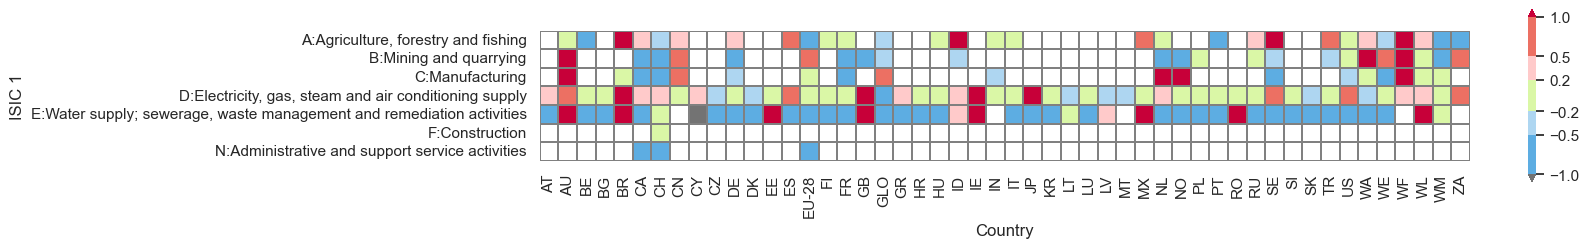

In [28]:
grouped = M['dev'].groupby([M["ISIC 1"], M['CountryCode']]).median()  #.agg("mean")

sns.set(font_scale=1.0)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

fig, ax = plt.subplots(figsize=(15,15))

# Legend
bounds = [-1.0,-0.5, -0.2, 0.2, 0.5, 1.0]
cmap = mpl.colors.ListedColormap(['#5dade2', '#aed6f1', '#DAF7A6', '#ffcaca', '#ec7063'])
cmap.set_over('#C70039')
cmap.set_under('#737373')

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax = sns.heatmap(grouped.unstack(), annot=False, ax=ax, cmap=cmap, cbar=True, square=True, norm=norm, 
                 xticklabels=True, yticklabels=True, # ensure all labels are displayed
                 linewidths=0.1, linecolor='grey',  # grid
                 vmin=min(bounds), vmax=max(bounds),
                  cbar_kws={
                     'orientation': 'vertical', 
                     'ticks': bounds,
                     'extend': 'both',
                     'boundaries': [-1000.0] + bounds + [1000.0], 
                     'spacing':"proportional",
                      'shrink': 0.15,
                 }
                )

# X - Y axis labels
ax.set_ylabel('ISIC 1')
ax.set_xlabel('Country')

### Match ISIC 1 classifications to PTN (best fitting, i.e. most frequently used)

In [29]:
# how do products and ISIC 1 classifications match?
M.groupby(['ProductTypeName','ISIC 1']).size().reset_index().rename(columns={0:'count'}) #.to_clipboard()

,ProductTypeName,ISIC 1,count
0,Aluminium and aluminium products,C:Manufacturing,52
1,Aluminium ores and concentrates,B:Mining and quarrying,1
2,Aluminium ores and concentrates,C:Manufacturing,1
3,Animal products nec,"A:Agriculture, forestry and fishing",2
4,Basic iron and steel and of ferro-alloys and f...,C:Manufacturing,21
...,...,...,...
124,"Vegetables, fruit, nuts",C:Manufacturing,2
125,Wheat,"A:Agriculture, forestry and fishing",16
126,Wood and products of wood and cork (except fur...,"A:Agriculture, forestry and fishing",1
127,Wood and products of wood and cork (except fur...,C:Manufacturing,72


In [30]:
best_matching_PTN_ISIC1 = M[['ProductTypeName','ISIC 1']].groupby(['ProductTypeName']).agg(lambda x: [y if isinstance(y, str) else "" for y in x.value_counts(dropna=False).index][0] )
print(best_matching_PTN_ISIC1.loc['Beverages'].values[0])
#best_matching_PTN_ISIC1.to_clipboard()
best_matching_PTN_ISIC1

C:Manufacturing


,ISIC 1
ProductTypeName,
Aluminium and aluminium products,C:Manufacturing
Aluminium ores and concentrates,C:Manufacturing
Animal products nec,"A:Agriculture, forestry and fishing"
Basic iron and steel and of ferro-alloys and first products thereof,C:Manufacturing
Beverages,C:Manufacturing
...,...
Uranium and thorium ores,B:Mining and quarrying
"Vegetables, fruit, nuts","A:Agriculture, forestry and fishing"
Wheat,"A:Agriculture, forestry and fishing"


In [31]:
# group by PTN and country code and add best matched ISIC 1
grouped = M[['dev']].groupby([M['ProductTypeName'], M["CountryCode"]]).median() 
unstacked = grouped.unstack()
unstacked = unstacked.droplevel(level=0, axis=1)
#unstacked = unstacked.reset_index(level=0)
unstacked = pd.merge(unstacked, best_matching_PTN_ISIC1, on='ProductTypeName', how='inner')
#unstacked.reset_index(inplace=True)
print(unstacked.shape)
unstacked.head()

(84, 51)


,AT,AU,BE,BG,BR,CA,CH,CN,CY,CZ,DE,DK,EE,ES,EU-28,FI,FR,GB,GLO,GR,HR,HU,ID,IE,IN,IT,JP,KR,LT,LU,LV,MT,MX,NL,NO,PL,PT,RO,RU,SE,SI,SK,TR,US,WA,WE,WF,WL,WM,ZA,ISIC 1
ProductTypeName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aluminium and aluminium products,NaN,NaN,NaN,NaN,NaN,-0.627,NaN,0.0948,NaN,NaN,NaN,NaN,NaN,NaN,-0.965,NaN,NaN,NaN,-0.696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0272,-0.73,0.0295,-0.118,0.0438,NaN,C:Manufacturing
Aluminium ores and concentrates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C:Manufacturing
Animal products nec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.44,NaN,NaN,NaN,NaN,NaN,NaN,"A:Agriculture, forestry and fishing"
Basic iron and steel and of ferro-alloys and first products thereof,NaN,NaN,NaN,NaN,NaN,-0.833,NaN,1.23,NaN,NaN,NaN,NaN,NaN,NaN,-0.469,NaN,NaN,NaN,-0.655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C:Manufacturing
Beverages,NaN,NaN,NaN,NaN,NaN,NaN,-0.974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.98,NaN,NaN,NaN,NaN,NaN,NaN,C:Manufacturing


In [32]:
# sort by ISIC 1 and PTN and add both as index
#unstacked = unstacked.sort_values(by = ['ISIC 1', 'ProductTypeName'])

# Filter out treatment

# Filter out where no ISIC 1 information is available
#unstacked['ISIC 1'].unique()
#unstacked = unstacked.drop(unstacked[unstacked['ISIC 1'] == ""].index)

# Drop ISIC from index and reset to PTN
unstacked = unstacked.drop('ISIC 1', axis=1)
unstacked = unstacked.reset_index().set_index(['ProductTypeName'])
#unstacked = unstacked.reset_index().set_index(['ISIC 1', 'ProductTypeName'])
print(unstacked.shape)
unstacked.head()

(84, 50)


,AT,AU,BE,BG,BR,CA,CH,CN,CY,CZ,DE,DK,EE,ES,EU-28,FI,FR,GB,GLO,GR,HR,HU,ID,IE,IN,IT,JP,KR,LT,LU,LV,MT,MX,NL,NO,PL,PT,RO,RU,SE,SI,SK,TR,US,WA,WE,WF,WL,WM,ZA
ProductTypeName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aluminium and aluminium products,NaN,NaN,NaN,NaN,NaN,-0.627,NaN,0.0948,NaN,NaN,NaN,NaN,NaN,NaN,-0.965,NaN,NaN,NaN,-0.696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0272,-0.73,0.0295,-0.118,0.0438,NaN
Aluminium ores and concentrates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Animal products nec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.44,NaN,NaN,NaN,NaN,NaN,NaN
Basic iron and steel and of ferro-alloys and first products thereof,NaN,NaN,NaN,NaN,NaN,-0.833,NaN,1.23,NaN,NaN,NaN,NaN,NaN,NaN,-0.469,NaN,NaN,NaN,-0.655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beverages,NaN,NaN,NaN,NaN,NaN,NaN,-0.974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.98,NaN,NaN,NaN,NaN,NaN,NaN


(84, 50)


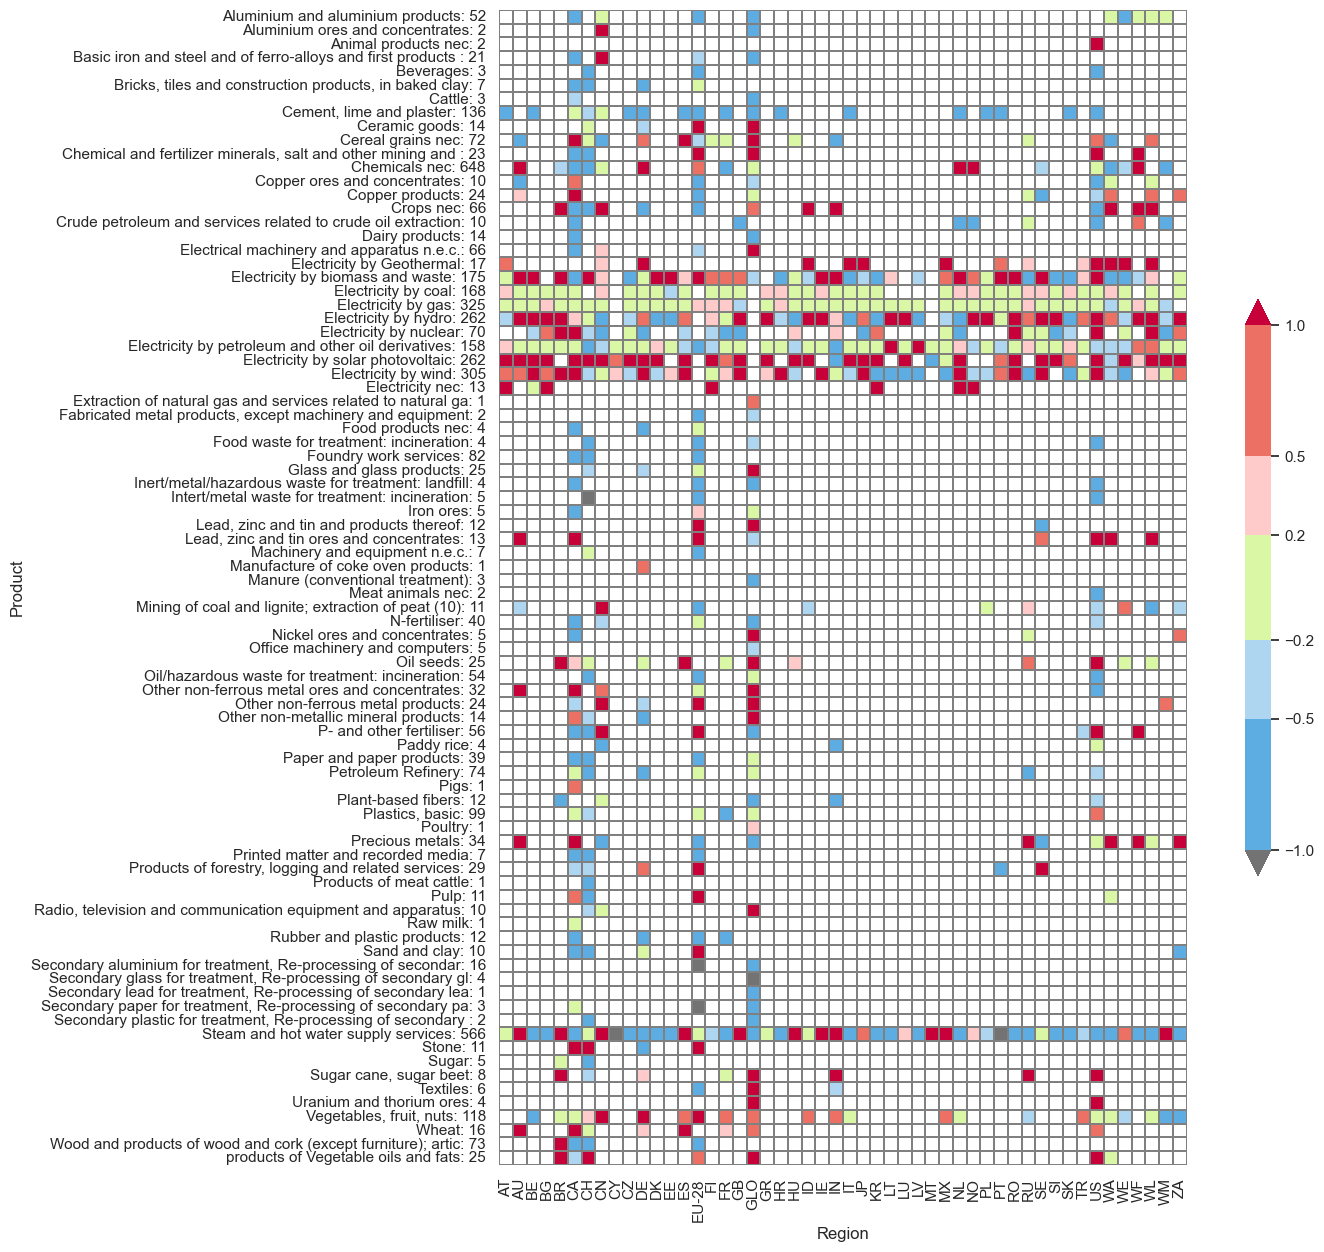

In [33]:
#grouped = M['dev'].groupby([M['ProductTypeName'], M["CountryCode"]]).median()  #.agg("mean")
#unstacked = grouped.unstack()
print(unstacked.shape)

sns.set(font_scale=1.0)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

fig, ax = plt.subplots(figsize=(15,15))

# Legend
bounds = [-1.0,-0.5, -0.2, 0.2, 0.5, 1.0]
cmap = mpl.colors.ListedColormap(['#5dade2', '#aed6f1', '#DAF7A6', '#ffcaca', '#ec7063'])
cmap.set_over('#C70039')
cmap.set_under('#737373')

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax = sns.heatmap(unstacked, annot=False, ax=ax, cmap=cmap, cbar=True, square=True, norm=norm, 
                 xticklabels=True, yticklabels=True, # ensure all labels are displayed
                 linewidths=0.1, linecolor='grey',  # grid
                 vmin=min(bounds), vmax=max(bounds),
                  cbar_kws={
                     'orientation': 'vertical', 
                     'ticks': bounds,
                     'extend': 'both',
                     'boundaries': [-1000.0] + bounds + [1000.0], 
                     'spacing':"proportional",
                      'shrink': 0.5,
                 }
                )

ytl = ax.set_yticklabels(add_sample_size(ax.get_yticklabels(), 'ProductTypeName', get_ISIC1=False, max_length=60))  # add sample sizes to yticklabels

# X - Y axis labels
ax.set_ylabel('Product')
ax.set_xlabel('Region')

#fig.savefig(f"{SCENARIO_PATH}figures/Dev_by_PTN_region_manual.png", bbox_inches='tight') 
#fig.savefig(f"{SCENARIO_PATH}figures/Figure6.svg", bbox_inches='tight') 
#fig.savefig(f"{SCENARIO_PATH}figures/Figure6.pdf", bbox_inches='tight') 
fig.savefig(f"{SCENARIO_PATH}figures/Figure 4.jpg", bbox_inches='tight', dpi=300) 

# D) Coefficient of variation

# Functions


In [34]:
def limit_string(text, max_length=50):
    return (text[:max_length] + '..') if len(text) > max_length else text

### Hack for converting MJ --> kWh (in EX)

In [35]:
# got a SettingWithCopy warning and thus solved it like this... a bit complicated and should only be executed ONCE!
mapping = {False: 1.0, True: 3.6}
conversion_factors = EX.ProductTypeName.str.match('Electricity').map(mapping)
EX["CarbonFootprint"] *= conversion_factors
EX.loc[EX.ProductTypeName.str.match('Electricity')]['CarbonFootprint'].head(2)

88     1.3
89   0.618
Name: CarbonFootprint, dtype: float64

###  Get a "ProductTypeNames" list

In [36]:
PTN = [name for name, group in M.groupby(M['ProductTypeName'])]
PTN

['Aluminium and aluminium products',
 'Aluminium ores and concentrates',
 'Animal products nec',
 'Basic iron and steel and of ferro-alloys and first products thereof',
 'Beverages',
 'Bricks, tiles and construction products, in baked clay',
 'Cattle',
 'Cement, lime and plaster',
 'Ceramic goods',
 'Cereal grains nec',
 'Chemical and fertilizer minerals, salt and other mining and quarrying products n.e.c.',
 'Chemicals nec',
 'Copper ores and concentrates',
 'Copper products',
 'Crops nec',
 'Crude petroleum and services related to crude oil extraction, excluding surveying',
 'Dairy products',
 'Electrical machinery and apparatus n.e.c.',
 'Electricity by Geothermal',
 'Electricity by biomass and waste',
 'Electricity by coal',
 'Electricity by gas',
 'Electricity by hydro',
 'Electricity by nuclear',
 'Electricity by petroleum and other oil derivatives',
 'Electricity by solar photovoltaic',
 'Electricity by wind',
 'Electricity nec',
 'Extraction of natural gas and services related 

## Statistics for each db

In [37]:
stats_types = ['count', 'mean', 'median', 'std', 'var', 'min', 'max', lambda x: st.sem(x)]
IPCC = "('IPCC 2013\', \'climate change\', \'GWP 100a\')"

## EXIOBASE results by Productsector

In [38]:
#count = lambda x: x.count()
EX_stats_all = EX['CarbonFootprint'].groupby(EX['ProductTypeName']).agg((stats_types))
EX_stats_all.rename(columns={'<lambda>': 'sem'}, inplace=True)
EX_stats_all['mean_abs'] = EX_stats_all['mean'].abs()
print(EX_stats_all['count'].sum())
print(EX_stats_all.shape)
EX_stats_all.head()

7012
(162, 9)


,count,mean,median,std,var,min,max,<lambda_0>,mean_abs
ProductTypeName,,,,,,,,,
Air transport services,50,1.61e+03,1.43e+03,1.07e+03,1.15e+06,-2.33e+03,5.75e+03,152,1.61e+03
Aluminium and aluminium products,34,26.5,22.5,15.3,233,7.99,77.2,2.62,26.5
Aluminium ores and concentrates,20,0.278,0.125,0.44,0.194,0.0172,1.67,0.0984,0.278
Animal products nec,47,5.15,3.67,5.3,28.1,0.33,28.7,0.774,5.15
"Ash for treatment, Re-processing of ash into clinker",39,-1.02,-0.872,0.784,0.614,-5.66,-0.268,0.125,1.02


#### limit to matched sectors

In [39]:
EX_stats = EX_stats_all.loc[PTN]
print(EX_stats['count'].sum())
print(EX_stats.shape)
EX_stats.head()

3678
(84, 9)


,count,mean,median,std,var,min,max,<lambda_0>,mean_abs
ProductTypeName,,,,,,,,,
Aluminium and aluminium products,34,26.5,22.5,15.3,233,7.99,77.2,2.62,26.5
Aluminium ores and concentrates,20,0.278,0.125,0.44,0.194,0.0172,1.67,0.0984,0.278
Animal products nec,47,5.15,3.67,5.3,28.1,0.33,28.7,0.774,5.15
Basic iron and steel and of ferro-alloys and first products thereof,45,4.07,3.36,2.35,5.54,1.22,11.2,0.351,4.07
Beverages,50,1.07,0.721,1.29,1.67,0.195,8.44,0.183,1.07


## Ecoinvent results by Productsector

Differently than for EX this is just looking at the ecoinvent results WITHIN the matched datasets. However, I argue that this is enough. The alternative would be to look at all ecoinvent activity-product combinations in  the database for all geographies. However, as Exiobase is essentially covering all world regions, the loss of geographical resolution is small here (essentially all ecoinvent geographies are included in the comparison except for RoW). This is thus the simpler and virtually as good variant. The other alternative (looking at all ecoinvent) is examined in the *"statistical_more_variance_in_ecoinvent_1.ipynb"*

In [40]:
EI_stats = M.groupby(['ProductTypeName'])[IPCC].agg((stats_types))
EI_stats.rename(columns={'<lambda>': 'sem'}, inplace=True)
EI_stats['mean_abs'] = EI_stats['mean'].abs()
print(EI_stats.shape)
EI_stats.head()

(84, 9)


C:\Users\steub\miniconda3\envs\ab\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\steub\miniconda3\envs\ab\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,count,mean,median,std,var,min,max,<lambda_0>,mean_abs
ProductTypeName,,,,,,,,,
Aluminium and aluminium products,52,11.1,7.49,8.94,79.9,0.162,33.4,1.24,11.1
Aluminium ores and concentrates,2,2.4,2.4,3.39,11.5,0.00631,4.8,2.4,2.4
Animal products nec,2,24.7,24.7,23,531,8.41,41,16.3,24.7
Basic iron and steel and of ferro-alloys and first products thereof,21,3.08,2.23,2.93,8.59,0.16,11.7,0.64,3.08
Beverages,3,0.0326,0.0325,0.00838,7.03e-05,0.0243,0.0411,0.00484,0.0326


# Joined EX-EI results by Productsector

These statistics refer to 
- all geographically disaggregated EX sectors (excluding those with zero Carbonfootprint, i.e. sectors not present in certain regions) (n ~ 3480)
- all ecoinvent activities matched to the productsectors (i.e. activity-product-geo combinations) (n ~ 4561)

In [41]:
EXI = pd.merge(EX_stats, EI_stats,  how='left', on=['ProductTypeName'])
print("x = Exiobase, y = ecoinvent")

x = Exiobase, y = ecoinvent


#### Add deviation results

In [42]:
dev_by_PTN = M.groupby(M['ProductTypeName']).median()['dev']
EXI = EXI.join(dev_by_PTN, how='inner')
EXI.head(15)

,count_x,mean_x,median_x,std_x,var_x,min_x,max_x,<lambda_0>_x,mean_abs_x,count_y,mean_y,median_y,std_y,var_y,min_y,max_y,<lambda_0>_y,mean_abs_y,dev
ProductTypeName,,,,,,,,,,,,,,,,,,,
Aluminium and aluminium products,34,26.5,22.5,15.3,233,7.99,77.2,2.62,26.5,52,11.1,7.49,8.94,79.9,0.162,33.4,1.24,11.1,-0.573
Aluminium ores and concentrates,20,0.278,0.125,0.44,0.194,0.0172,1.67,0.0984,0.278,2,2.4,2.4,3.39,11.5,0.00631,4.8,2.4,2.4,27.8
Animal products nec,47,5.15,3.67,5.3,28.1,0.33,28.7,0.774,5.15,2,24.7,24.7,23,531,8.41,41,16.3,24.7,2.44
Basic iron and steel and of ferro-alloys and first products thereof,45,4.07,3.36,2.35,5.54,1.22,11.2,0.351,4.07,21,3.08,2.23,2.93,8.59,0.16,11.7,0.64,3.08,-0.513
Beverages,50,1.07,0.721,1.29,1.67,0.195,8.44,0.183,1.07,3,0.0326,0.0325,0.00838,7.03e-05,0.0243,0.0411,0.00484,0.0326,-0.974
"Bricks, tiles and construction products, in baked clay",50,2.86,0.552,8.14,66.3,0.0174,51.6,1.15,2.86,7,0.145,0.136,0.131,0.0171,0.0165,0.361,0.0494,0.145,-0.662
Cattle,50,21.2,16.6,24.3,592,6.63,173,3.44,21.2,3,9.24,9.36,1.34,1.8,7.85,10.5,0.774,9.24,-0.547
"Cement, lime and plaster",50,1.23,1.09,0.784,0.615,0.707,6.43,0.111,1.23,136,0.486,0.491,0.434,0.188,0,2.11,0.0372,0.486,-0.547
Ceramic goods,50,1.54,1.18,1.52,2.3,0.482,11.3,0.214,1.54,14,3.06,1.3,4.86,23.7,0,18.6,1.3,3.06,0.56


# Analyses

### Characterize the range of results for each PS as "small" or "large"

In [43]:
print("Minimum sample size for EXIOBASE:", min(EXI['count_x']), "and ecoinvent:", min(EXI['count_y']))

Minimum sample size for EXIOBASE: 12 and ecoinvent: 1


In [44]:
# coefficient of variation
EXI['EX_relative_std'] = EXI['std_x'] / EXI['mean_x'] 
EXI['EI_relative_std'] = EXI['std_y'] / EXI['mean_y']

print(EXI.shape)
# exclude inf and nan
EXI.replace([np.inf, -np.inf], np.nan, inplace=True)
EXI.dropna(inplace=True)
print(EXI.shape)
EXI

(84, 21)
(75, 21)


,count_x,mean_x,median_x,std_x,var_x,min_x,max_x,<lambda_0>_x,mean_abs_x,count_y,mean_y,median_y,std_y,var_y,min_y,max_y,<lambda_0>_y,mean_abs_y,dev,EX_relative_std,EI_relative_std
ProductTypeName,,,,,,,,,,,,,,,,,,,,,
Aluminium and aluminium products,34,26.5,22.5,15.3,233,7.99,77.2,2.62,26.5,52,11.1,7.49,8.94,79.9,0.162,33.4,1.24,11.1,-0.573,0.576,0.807
Aluminium ores and concentrates,20,0.278,0.125,0.44,0.194,0.0172,1.67,0.0984,0.278,2,2.4,2.4,3.39,11.5,0.00631,4.8,2.4,2.4,27.8,1.58,1.41
Animal products nec,47,5.15,3.67,5.3,28.1,0.33,28.7,0.774,5.15,2,24.7,24.7,23,531,8.41,41,16.3,24.7,2.44,1.03,0.933
Basic iron and steel and of ferro-alloys and first products thereof,45,4.07,3.36,2.35,5.54,1.22,11.2,0.351,4.07,21,3.08,2.23,2.93,8.59,0.16,11.7,0.64,3.08,-0.513,0.578,0.952
Beverages,50,1.07,0.721,1.29,1.67,0.195,8.44,0.183,1.07,3,0.0326,0.0325,0.00838,7.03e-05,0.0243,0.0411,0.00484,0.0326,-0.974,1.21,0.257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uranium and thorium ores,16,49.2,20.9,59.4,3.53e+03,0.568,215,14.9,49.2,4,54.4,57.1,42.9,1.84e+03,6.75,96.5,21.4,54.4,3.38,1.21,0.789
"Vegetables, fruit, nuts",50,0.263,0.222,0.186,0.0345,0.0866,1.36,0.0263,0.263,118,0.769,0.31,1.37,1.89,0.0604,9.01,0.126,0.769,0.379,0.706,1.79
Wheat,49,0.535,0.449,0.266,0.0705,0.184,1.99,0.0379,0.535,16,0.611,0.531,0.153,0.0235,0.416,0.858,0.0383,0.611,0.333,0.497,0.251


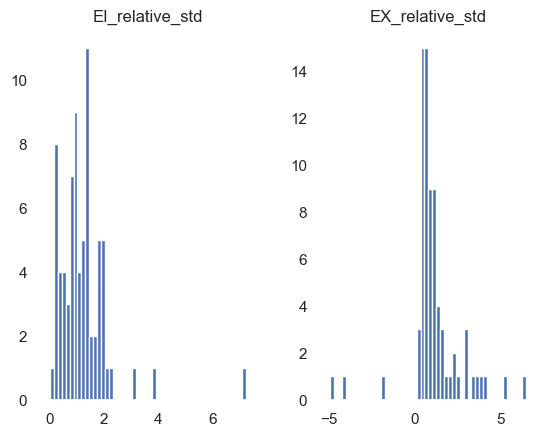

In [45]:
ax = EXI.hist(column=['EI_relative_std', 'EX_relative_std'], bins=50)

#### Difference in relative standard deviation (coefficient of variation)

In [46]:
# positive numbers indicate EXIOBASE should be improved, negative numbers indicate ecoinvent should be improved
EXI['improve_diff'] = EXI['EI_relative_std'] - EXI['EX_relative_std']
EXI

,count_x,mean_x,median_x,std_x,var_x,min_x,max_x,<lambda_0>_x,mean_abs_x,count_y,mean_y,median_y,std_y,var_y,min_y,max_y,<lambda_0>_y,mean_abs_y,dev,EX_relative_std,EI_relative_std,improve_diff
ProductTypeName,,,,,,,,,,,,,,,,,,,,,,
Aluminium and aluminium products,34,26.5,22.5,15.3,233,7.99,77.2,2.62,26.5,52,11.1,7.49,8.94,79.9,0.162,33.4,1.24,11.1,-0.573,0.576,0.807,0.232
Aluminium ores and concentrates,20,0.278,0.125,0.44,0.194,0.0172,1.67,0.0984,0.278,2,2.4,2.4,3.39,11.5,0.00631,4.8,2.4,2.4,27.8,1.58,1.41,-0.171
Animal products nec,47,5.15,3.67,5.3,28.1,0.33,28.7,0.774,5.15,2,24.7,24.7,23,531,8.41,41,16.3,24.7,2.44,1.03,0.933,-0.0981
Basic iron and steel and of ferro-alloys and first products thereof,45,4.07,3.36,2.35,5.54,1.22,11.2,0.351,4.07,21,3.08,2.23,2.93,8.59,0.16,11.7,0.64,3.08,-0.513,0.578,0.952,0.374
Beverages,50,1.07,0.721,1.29,1.67,0.195,8.44,0.183,1.07,3,0.0326,0.0325,0.00838,7.03e-05,0.0243,0.0411,0.00484,0.0326,-0.974,1.21,0.257,-0.949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uranium and thorium ores,16,49.2,20.9,59.4,3.53e+03,0.568,215,14.9,49.2,4,54.4,57.1,42.9,1.84e+03,6.75,96.5,21.4,54.4,3.38,1.21,0.789,-0.42
"Vegetables, fruit, nuts",50,0.263,0.222,0.186,0.0345,0.0866,1.36,0.0263,0.263,118,0.769,0.31,1.37,1.89,0.0604,9.01,0.126,0.769,0.379,0.706,1.79,1.08
Wheat,49,0.535,0.449,0.266,0.0705,0.184,1.99,0.0379,0.535,16,0.611,0.531,0.153,0.0235,0.416,0.858,0.0383,0.611,0.333,0.497,0.251,-0.246


# Relative std plot (coefficient of variation)

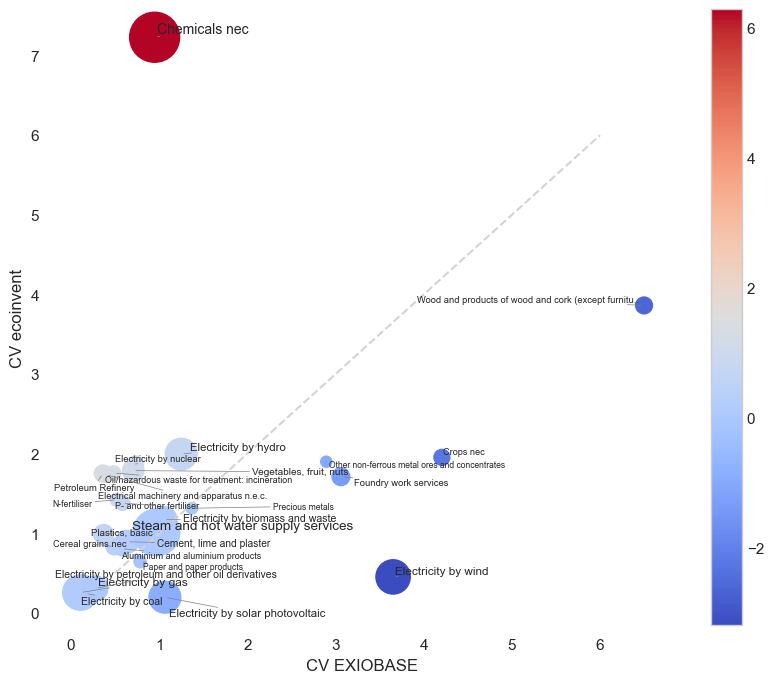

In [47]:
fig, ax = plt.subplots(figsize=(10,8))
plt.style.use(['seaborn-whitegrid'])  # 'default'

# exclude sectors with too small ecoinvent sample size
samplesize_ecoinvent_cutoff = 30
display_cutoff = 30
DF = EXI[EXI['count_y'] >= samplesize_ecoinvent_cutoff]

mini = round(DF['improve_diff'].min())
maxi = round(DF['improve_diff'].max())

divnorm = mpl.colors.TwoSlopeNorm(vmin=mini, vcenter=0, vmax=maxi)

ax = DF.plot.scatter(ax=ax, x='EX_relative_std', y='EI_relative_std', 
                     s=DF['count_y'] * 2,  # size of circle
                     c=DF['improve_diff'],  # color of circle
                     #norm=divnorm,
                     colormap="coolwarm", 
    )

ax.set_xlabel('CV EXIOBASE')
ax.set_ylabel('CV ecoinvent')

# diagonal line
ax.plot([0.5, maxi], [0.5, maxi], color='lightgrey', linestyle='--')

# text annotation
texts = []
for k, v in DF.iterrows():
    if v['count_y'] > display_cutoff:
        texts.append(plt.text(v['EX_relative_std'], v['EI_relative_std'], limit_string(k, max_length=50), 
                              fontsize=5+0.2*math.sqrt(v['count_y']), 
                    ))

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))        
        
fig.savefig(f"{SCENARIO_PATH}figures/figure_relative_std.png", bbox_inches='tight')
fig.savefig(f"{SCENARIO_PATH}figures/Figure8.svg", bbox_inches='tight')
fig.savefig(f"{SCENARIO_PATH}figures/Figure8.pdf", bbox_inches='tight')
#fig.savefig(f"{SCENARIO_PATH}figures/Figure 6.tif", bbox_inches='tight', dpi=300)  # 18 MB
fig.savefig(f"{SCENARIO_PATH}figures/Figure 6.jpg", bbox_inches='tight', dpi=300)